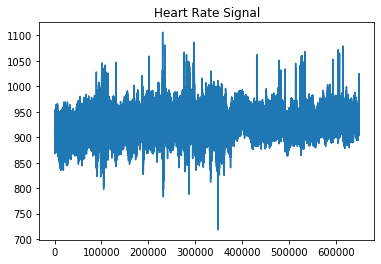

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
dataset = pd.read_csv("C:\\MySpace\\4th Year IT\\Data Analytics\\Deep-Learning-for-Heartbeat-classification\\mitbih_database\\205.csv") #Read data from CSV datafile
plt.title("Heart Rate Signal") #The title of our plot
plt.plot(dataset["'V1'"]) #Draw the plot object
plt.show() #Display the plot

In [3]:
dataset = pd.read_csv("C:\\MySpace\\4th Year IT\\Data Analytics\\Deep-Learning-for-Heartbeat-classification\\mitbih_database\\205.csv")
# Median Filter on V1 Lead 

# df = pd.read_csv("C:\\MySpace\\4th Year IT\\Data Analytics\\Deep-Learning-for-Heartbeat-classification\\mitbih_database\\205.csv")
# print(df)
data= dataset[dataset.columns[2]].to_numpy()
# print(data)
num_600 = medfilt(data, 601)
# print(num_600)

num_200 = medfilt(num_600,201)
# print(num_200)

dataset = medfilt(num_200, 27)

NameError: name 'medfilt' is not defined

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import medfilt


# print(dataset)

#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 0.75 #One-sided window size, as proportion of the sampling frequency
fs = 100 #The example dataset was recorded at 100Hz
mov_avg = dataset.rolling(int(hrw*fs)).mean() #Calculate moving average
#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw

avg_hr = (np.mean(dataset))
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset["'V1_mean'"] = mov_avg #Append the moving average to the dataframe
#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset:
    rollingmean = dataset["'V1_mean'"][listpos] #Get local mean
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1
    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1
ybeat = [dataset[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes
plt.title("Detected peaks in signal")
plt.xlim(0,2500)
plt.plot(dataset, alpha=0.5, color='blue') #Plot semi-transparent HR
plt.plot(mov_avg, color ='green') #Plot moving average
plt.scatter(peaklist, ybeat, color='red') #Plot detected peaks
plt.show()


TypeError: must be real number, not str

In [6]:
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# physionet data
# import wfdb
# from wfdb import processing

In [7]:
project_path = os.path.join(os.getcwd(), os.pardir)
data_path = os.path.join(project_path, 'data')
output_path = os.path.join(project_path, 'output')

# style settings
sns.set(style='whitegrid', rc={'axes.facecolor': '#EFF2F7'})

# sample frequency for Bobbi sensor
settings = {}
settings['fs'] = 500

In [8]:
def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))

In [9]:
def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, np.median(peak_group))
    return output

In [10]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity

In [31]:
df = pd.read_csv("C:\\MySpace\\4th Year IT\\Data Analytics\\Deep-Learning-for-Heartbeat-classification\\mitbih_database\\ecg.csv", sep=";", index_col="ms")
print (data, type(data))

[ 916  916  916 ...  951  948 1024] <class 'numpy.ndarray'>


Text(0, 0.5, 'Amplitude (arbitrary unit)')

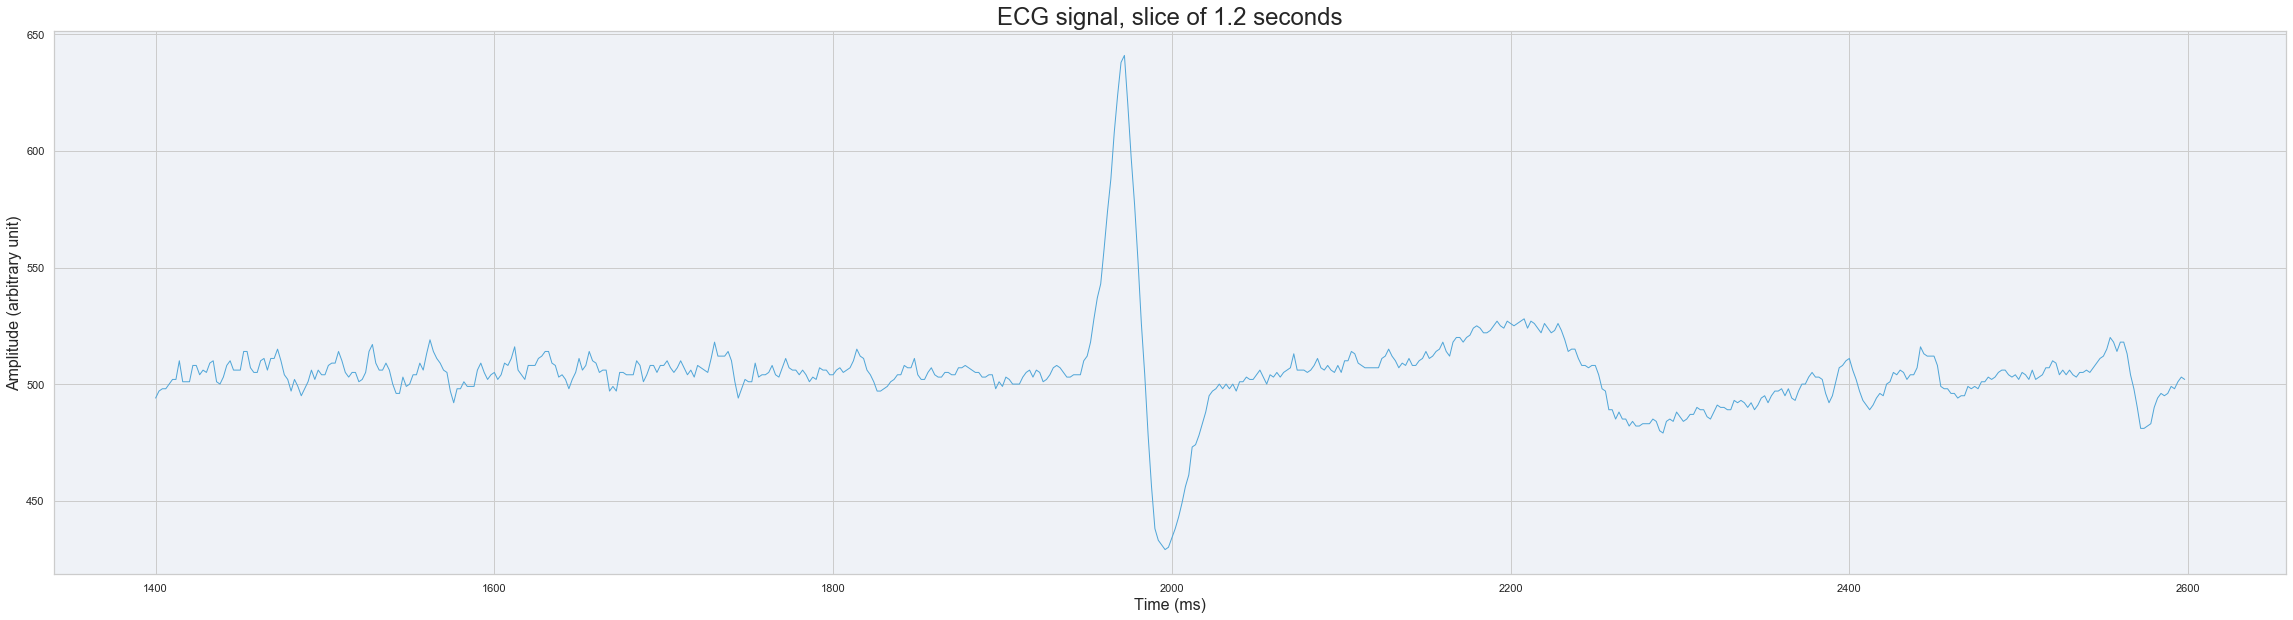

In [34]:
plt.figure(figsize=(40, 10))
# start = 0
# stop = 5000
start = 700
stop = 1300
duration = (stop-start) / settings['fs']
plt.title("ECG signal, slice of %.1f seconds" % duration, fontsize=24)
plt.plot(df[start:stop].index, df[start:stop].heartrate, color="#51A6D8", linewidth=1)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)

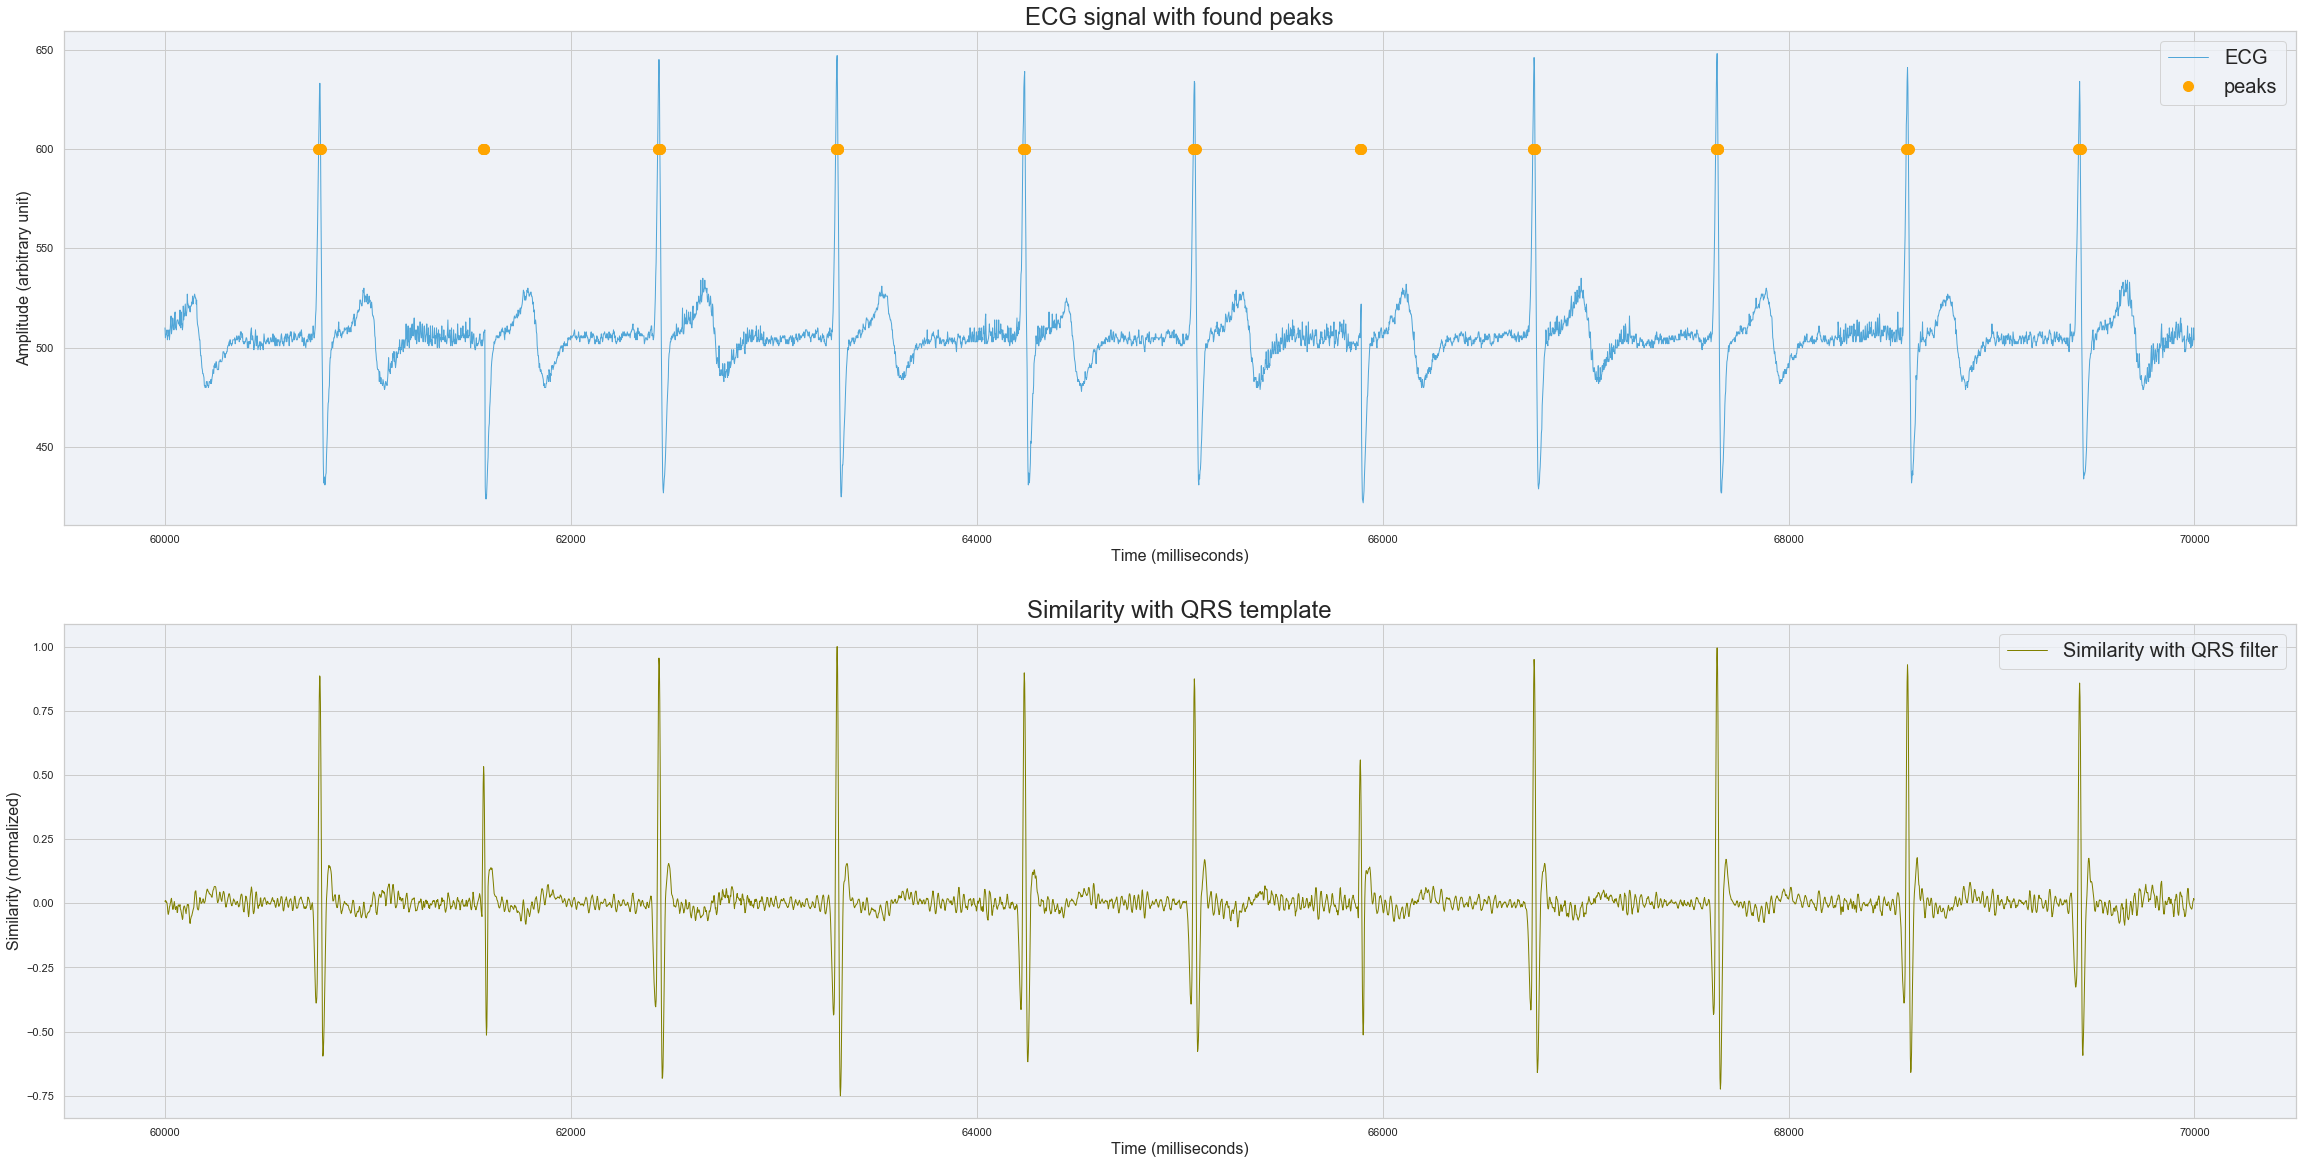

In [13]:
sampfrom = 60000
sampto = 70000
nr_plots = 1

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # get slice data of ECG data
    cond_slice = (df.index >= start) & (df.index < stop) 
    ecg_slice = df.heartrate[cond_slice]

    # detect peaks
    peaks, similarity = detect_peaks(ecg_slice, threshold=0.3)
    
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.subplot(211)
    plt.title("ECG signal with found peaks", fontsize=24)
    plt.plot(ecg_slice.index, ecg_slice, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(600, peaks.shape[0]), markersize=10, label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    
    plt.subplot(212)
    plt.title('Similarity with QRS template', fontsize=24)
    plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Similarity (normalized)", fontsize=16)
    
#     plt.savefig(, "peaks-%s-%s.png" % (start, stop)))

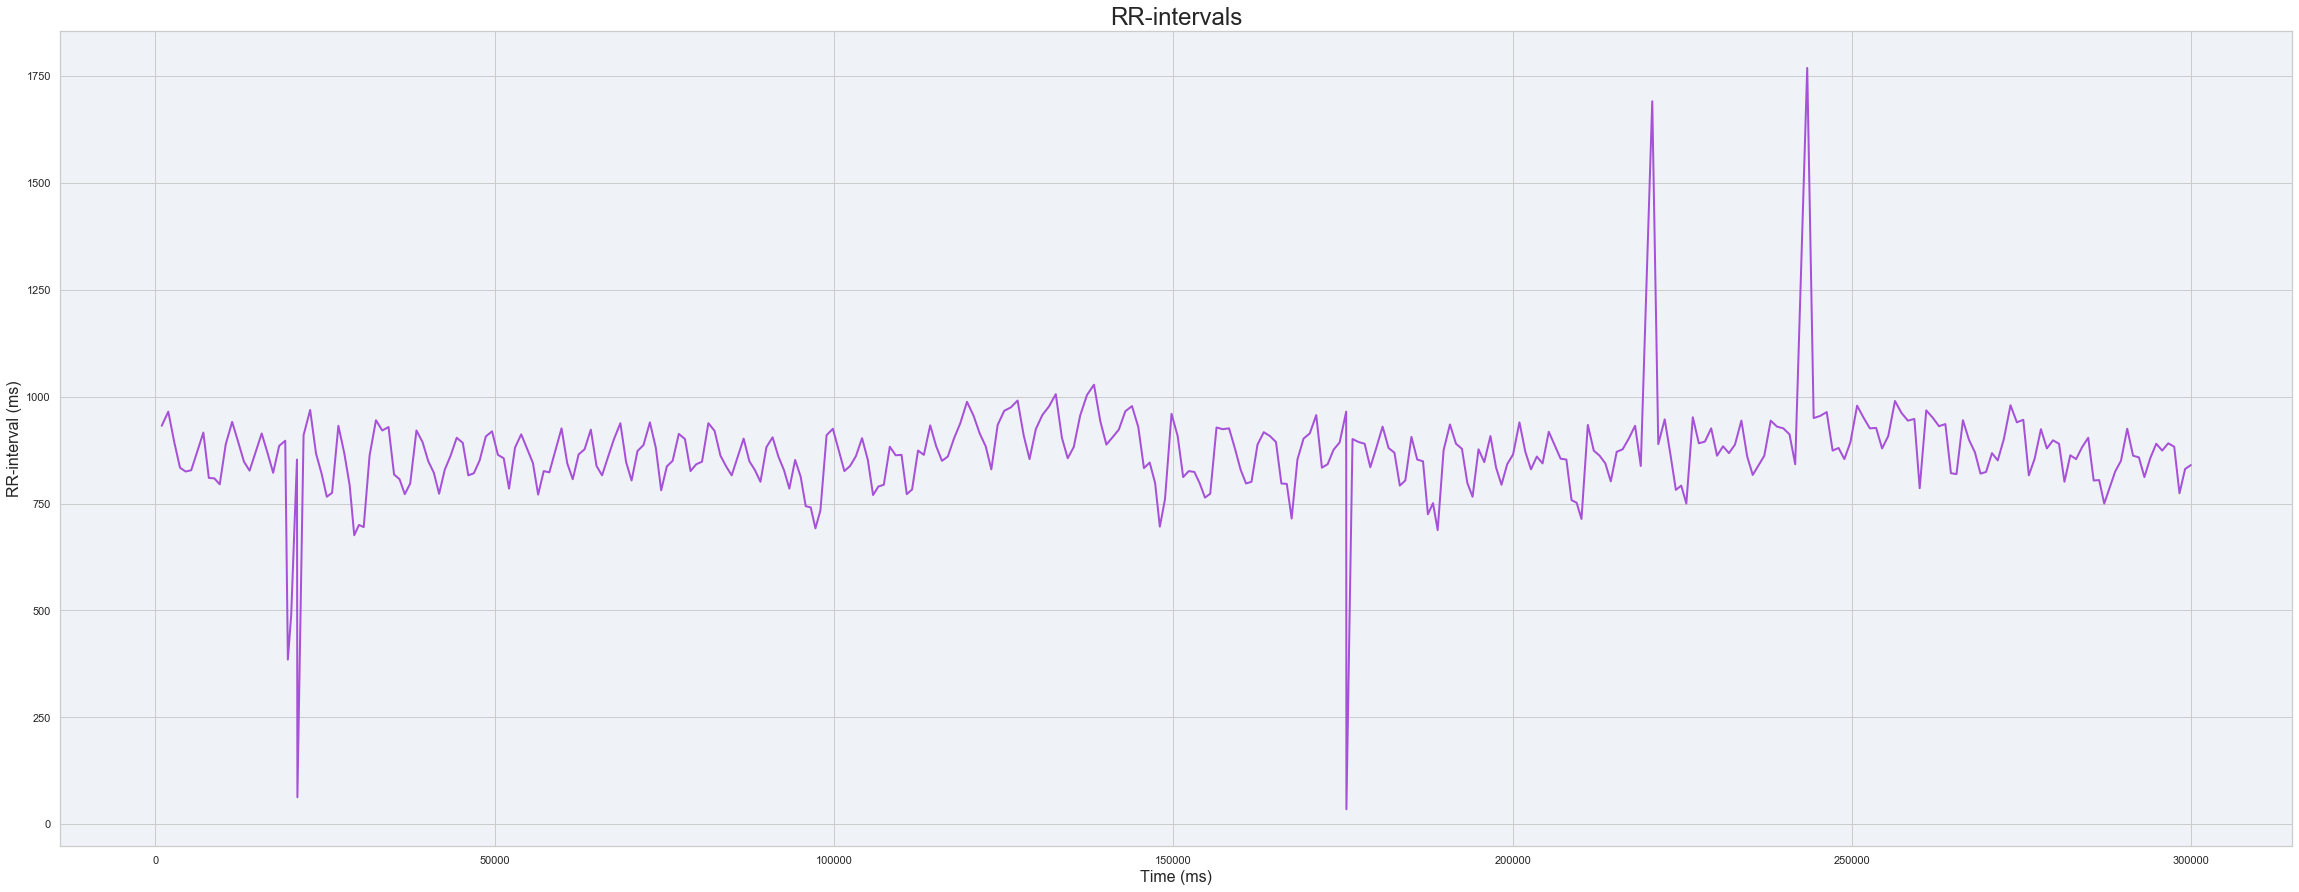

In [14]:
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

# plot RR-intervals
plt.figure(figsize=(40, 15))
plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(np.cumsum(rr), rr, label="RR-interval", color="#A651D8", linewidth=2)

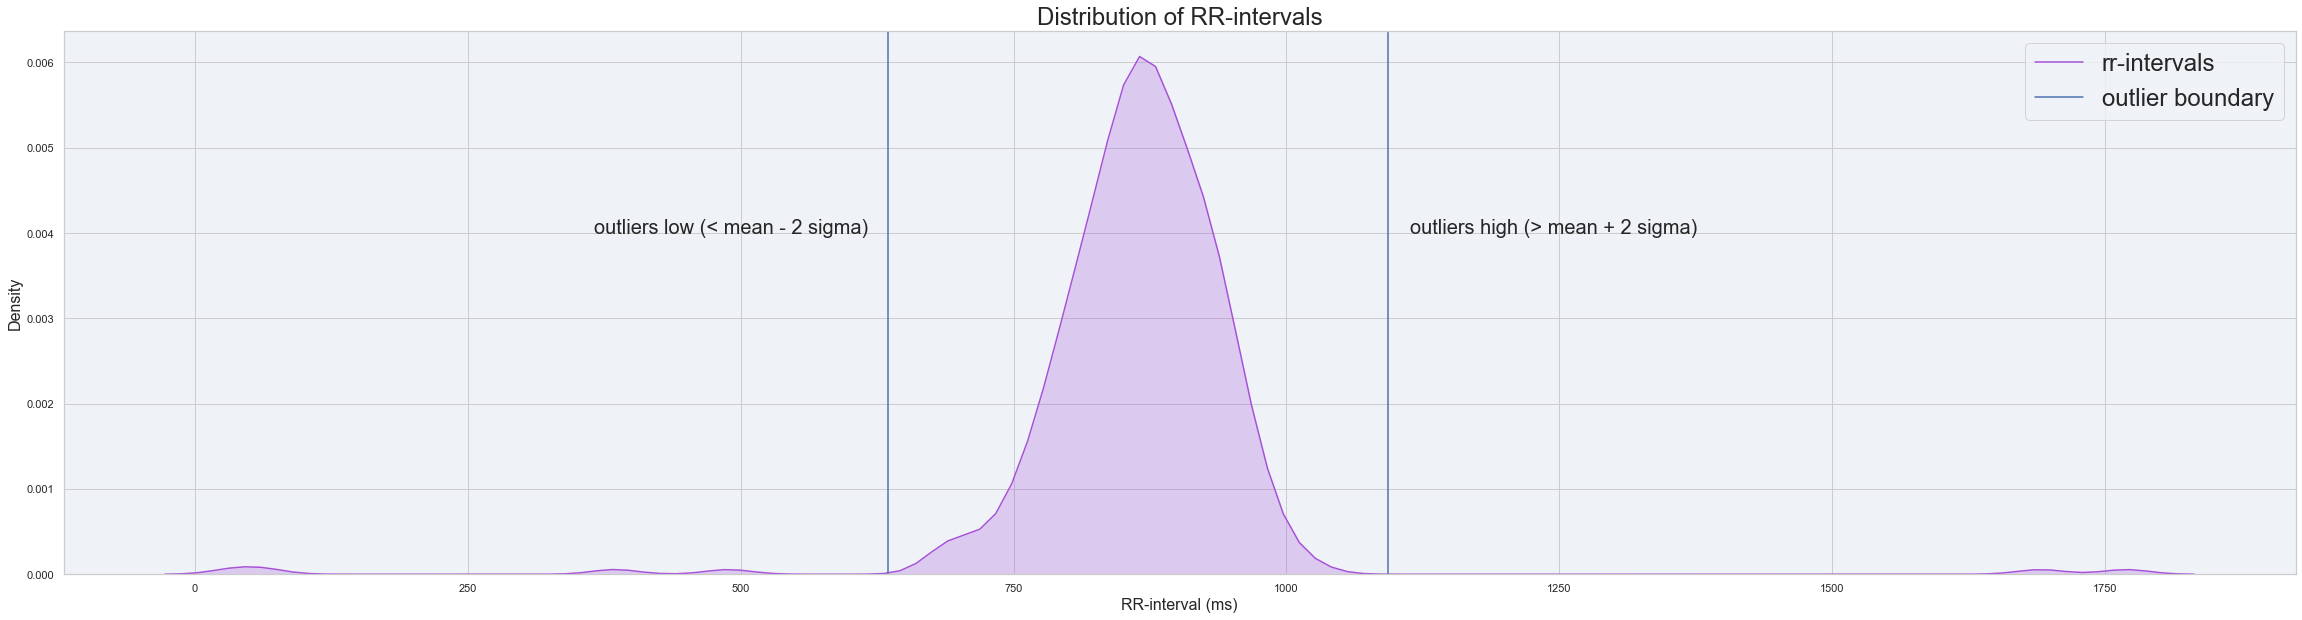

In [15]:
plt.figure(figsize=(40, 10))
plt.title("Distribution of RR-intervals", fontsize=24)
sns.kdeplot(rr, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr)-2 * np.std(rr)
outlier_high = np.mean(rr)+2 * np.std(rr)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 270, 0.004, "outliers low (< mean - 2 sigma)", fontsize=20)
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)", fontsize=20)

plt.xlabel("RR-interval (ms)", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.legend(fontsize=24)

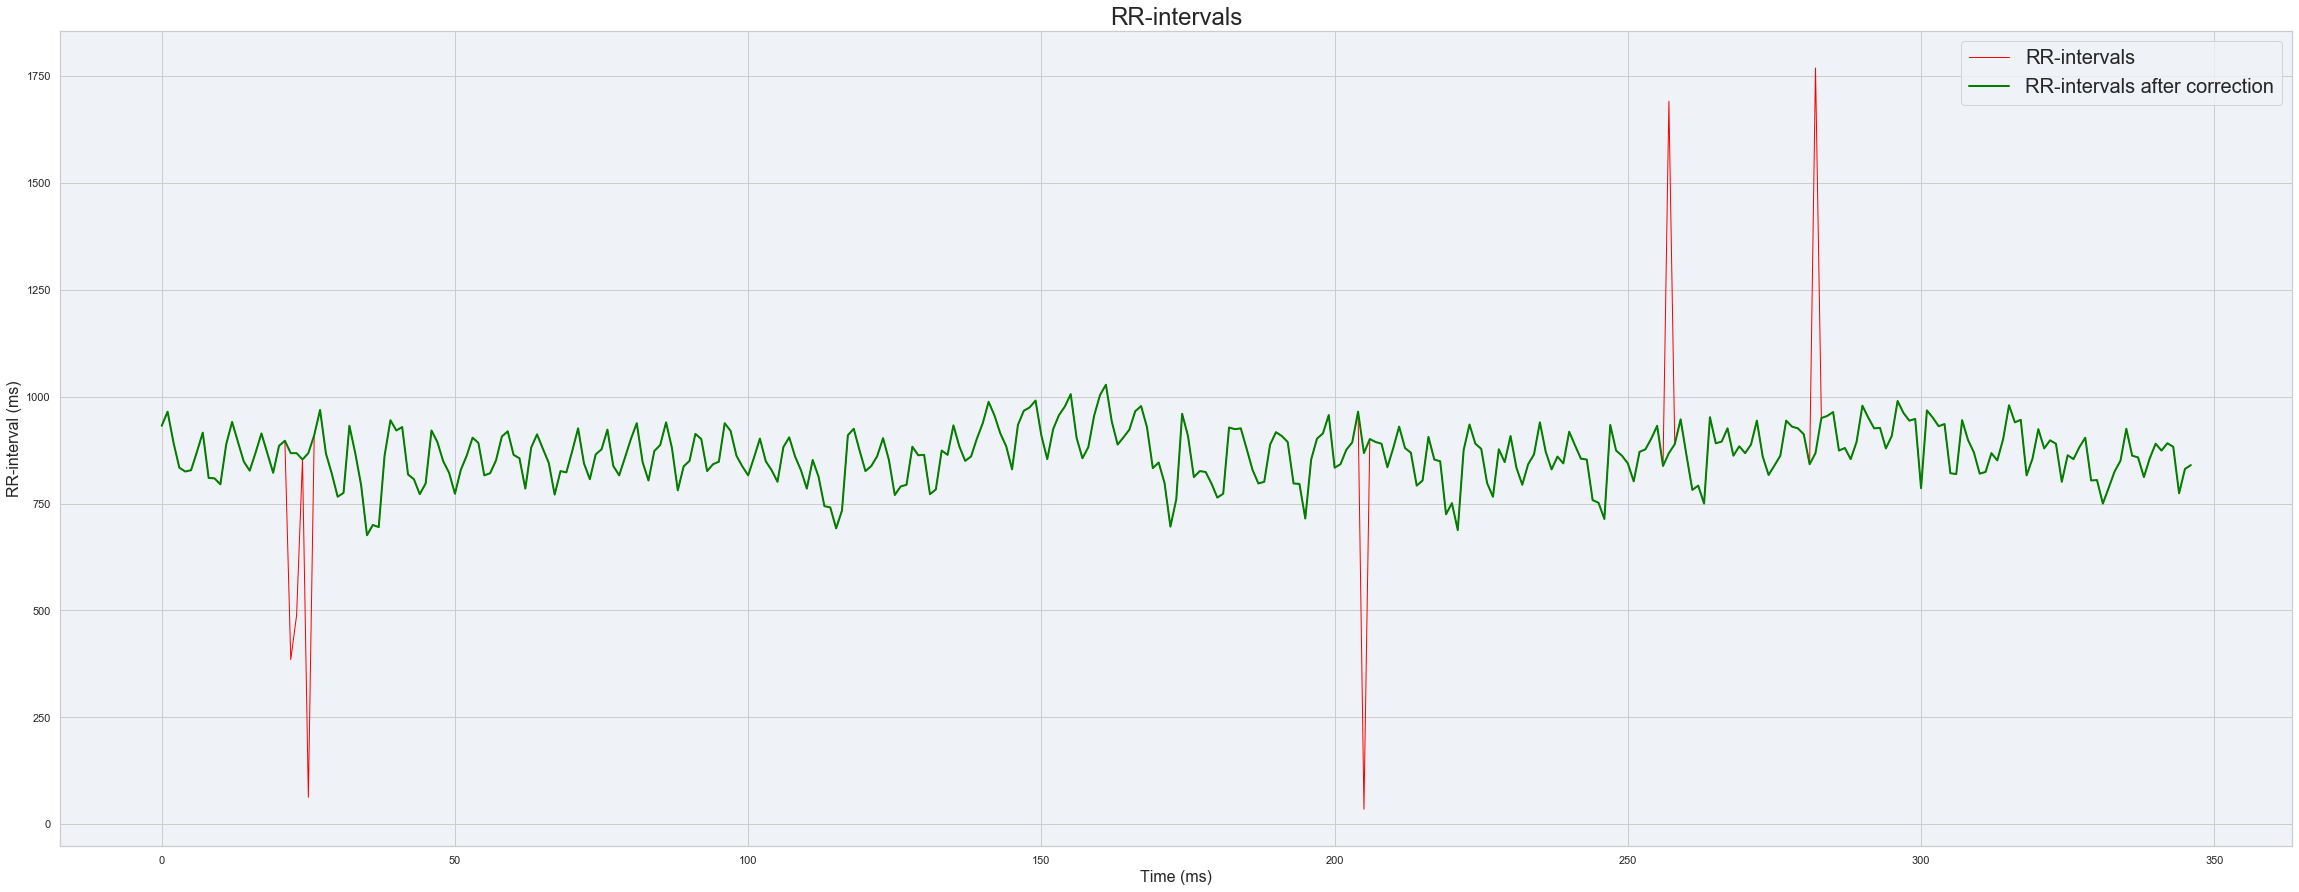

In [16]:
plt.figure(figsize=(40, 15))

rr_corrected = rr.copy()
rr_corrected[np.abs(zscore(rr)) > 2] = np.median(rr)

plt.title("RR-intervals", fontsize=24)
plt.xlabel("Time (ms)", fontsize=16)
plt.ylabel("RR-interval (ms)", fontsize=16)

plt.plot(rr, color="red", linewidth=1, label="RR-intervals")
plt.plot(rr_corrected, color="green", linewidth=2, label="RR-intervals after correction")
plt.legend(fontsize=20)

Int64Index([    70,     72,     74,     76,     78,     80,   1002,   1004,
              1006,   1008,
            ...
            299148, 299150, 299152, 299154, 299156, 299986, 299988, 299990,
            299992, 299994],
           dtype='int64', name='ms', length=2161)
[  1002.   1967.   2860.   3694.   4519.   5347.   6218.   7134.   7944.
   8753.   9548.  10437.  11378.  12272.  13120.  13947.  14816.  15730.
  16598.  17420.  18305.  19202.  19587.  20076.  20929.  20992.  21902.
  22871.  23738.  24558.  25324.  26099.  27031.  27899.  28692.  29368.
  30068.  30763.  31625.  32570.  33491.  34420.  35238.  36045.  36817.
  37614.  38535.  39429.  40278.  41100.  41873.  42702.  43564.  44468.
  45360.  46176.  46997.  47848.  48755.  49674.  50538.  51394.  52179.
  53060.  53972.  54850.  55695.  56466.  57292.  58115.  58988.  59914.
  60758.  61565.  62430.  63307.  64230.  65068.  65884.  66742.  67643.
  68581.  69428.  70232.  71105.  71992.  72932.  73812.  74593.  75

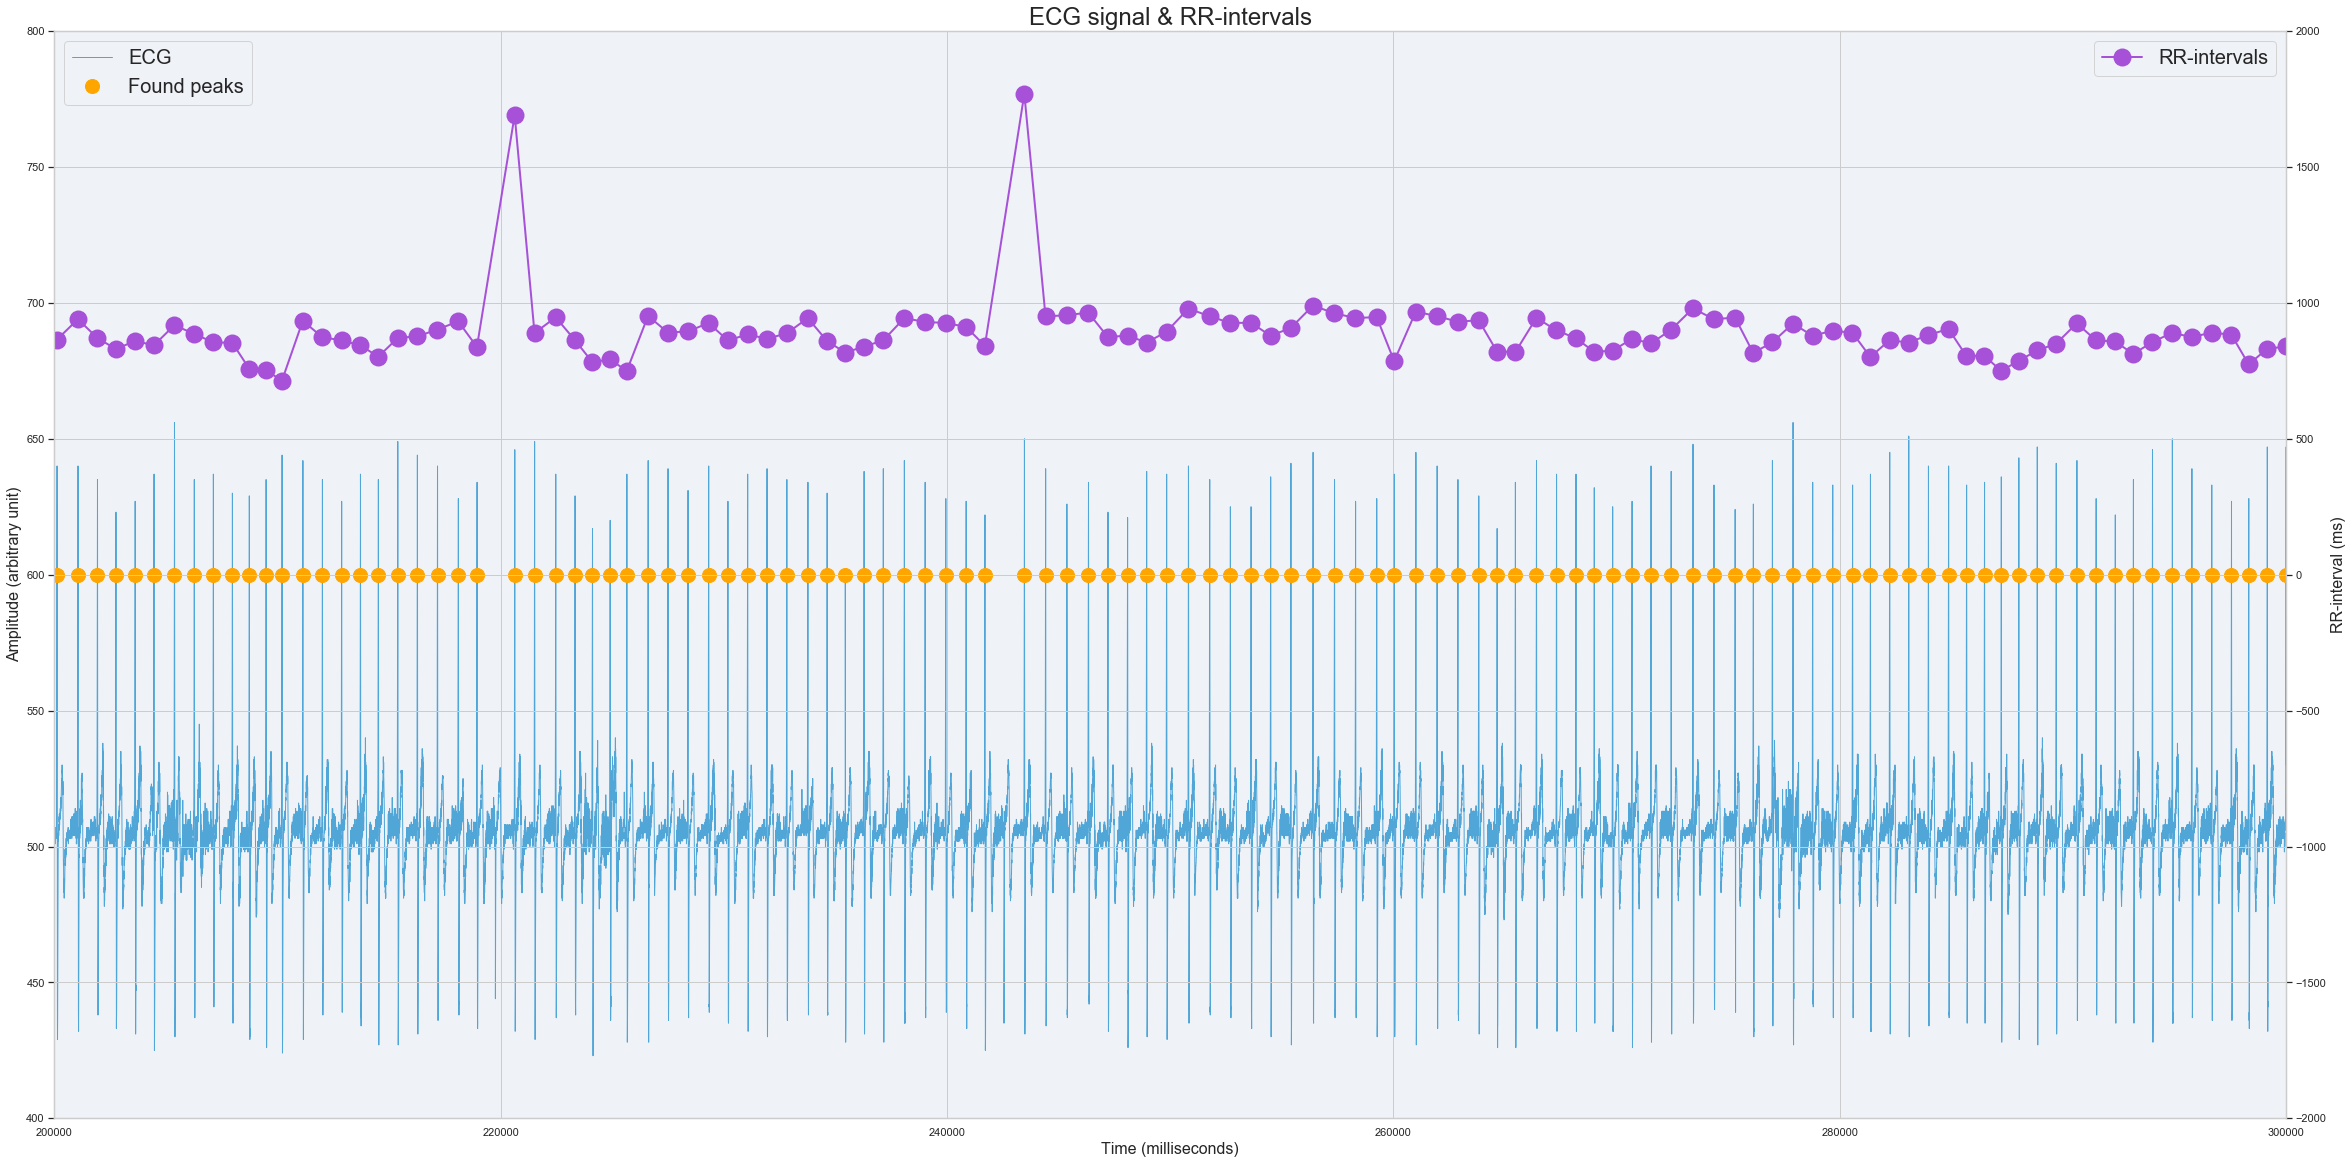

In [19]:
sampfrom = 200000
sampto = 300000
nr_plots = 1

# detect peaks
peaks, similarity = detect_peaks(df.heartrate, threshold=0.3)
print (peaks)

# group peaks so we get a single peak per beat (hopefully)
grouped_peaks = group_peaks(peaks)

# RR-intervals are the differences between successive peaks
rr = np.diff(grouped_peaks)

for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    # plot similarity
    plt.figure(figsize=(40, 20))

    plt.title("ECG signal & RR-intervals", fontsize=24)
    plt.plot(df.index, df.heartrate, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(grouped_peaks, np.repeat(600, grouped_peaks.shape[0]), markersize=14, label="Found peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper left", fontsize=20)
    plt.xlabel("Time (milliseconds)", fontsize=16)
    plt.ylabel("Amplitude (arbitrary unit)", fontsize=16)
    plt.gca().set_ylim(400, 800)
    
    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(rr)+peaks[0], rr, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
    print (np.cumsum(rr)+peaks[0], rr)
    ax2.set_xlim(start, stop)
    ax2.set_ylim(-2000, 2000)
    ax2.legend(loc="upper right", fontsize=20)

    plt.xlabel("Time (ms)", fontsize=16)
    plt.ylabel("RR-interval (ms)", fontsize=16)
    
# ax2 = plt.gca().twinx()
# ax2.plot(69, 71, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
# ax2.set_xlim(start, stop)
# ax2.set_ylim(-2000, 2000)
# ax2.legend(loc="upper right", fontsize=20)
    
#     plt.savefig(os.path.join(output_path, "ecg-with-rr-%s-%s.png" % (start, stop)))

IndexError: invalid index to scalar variable.

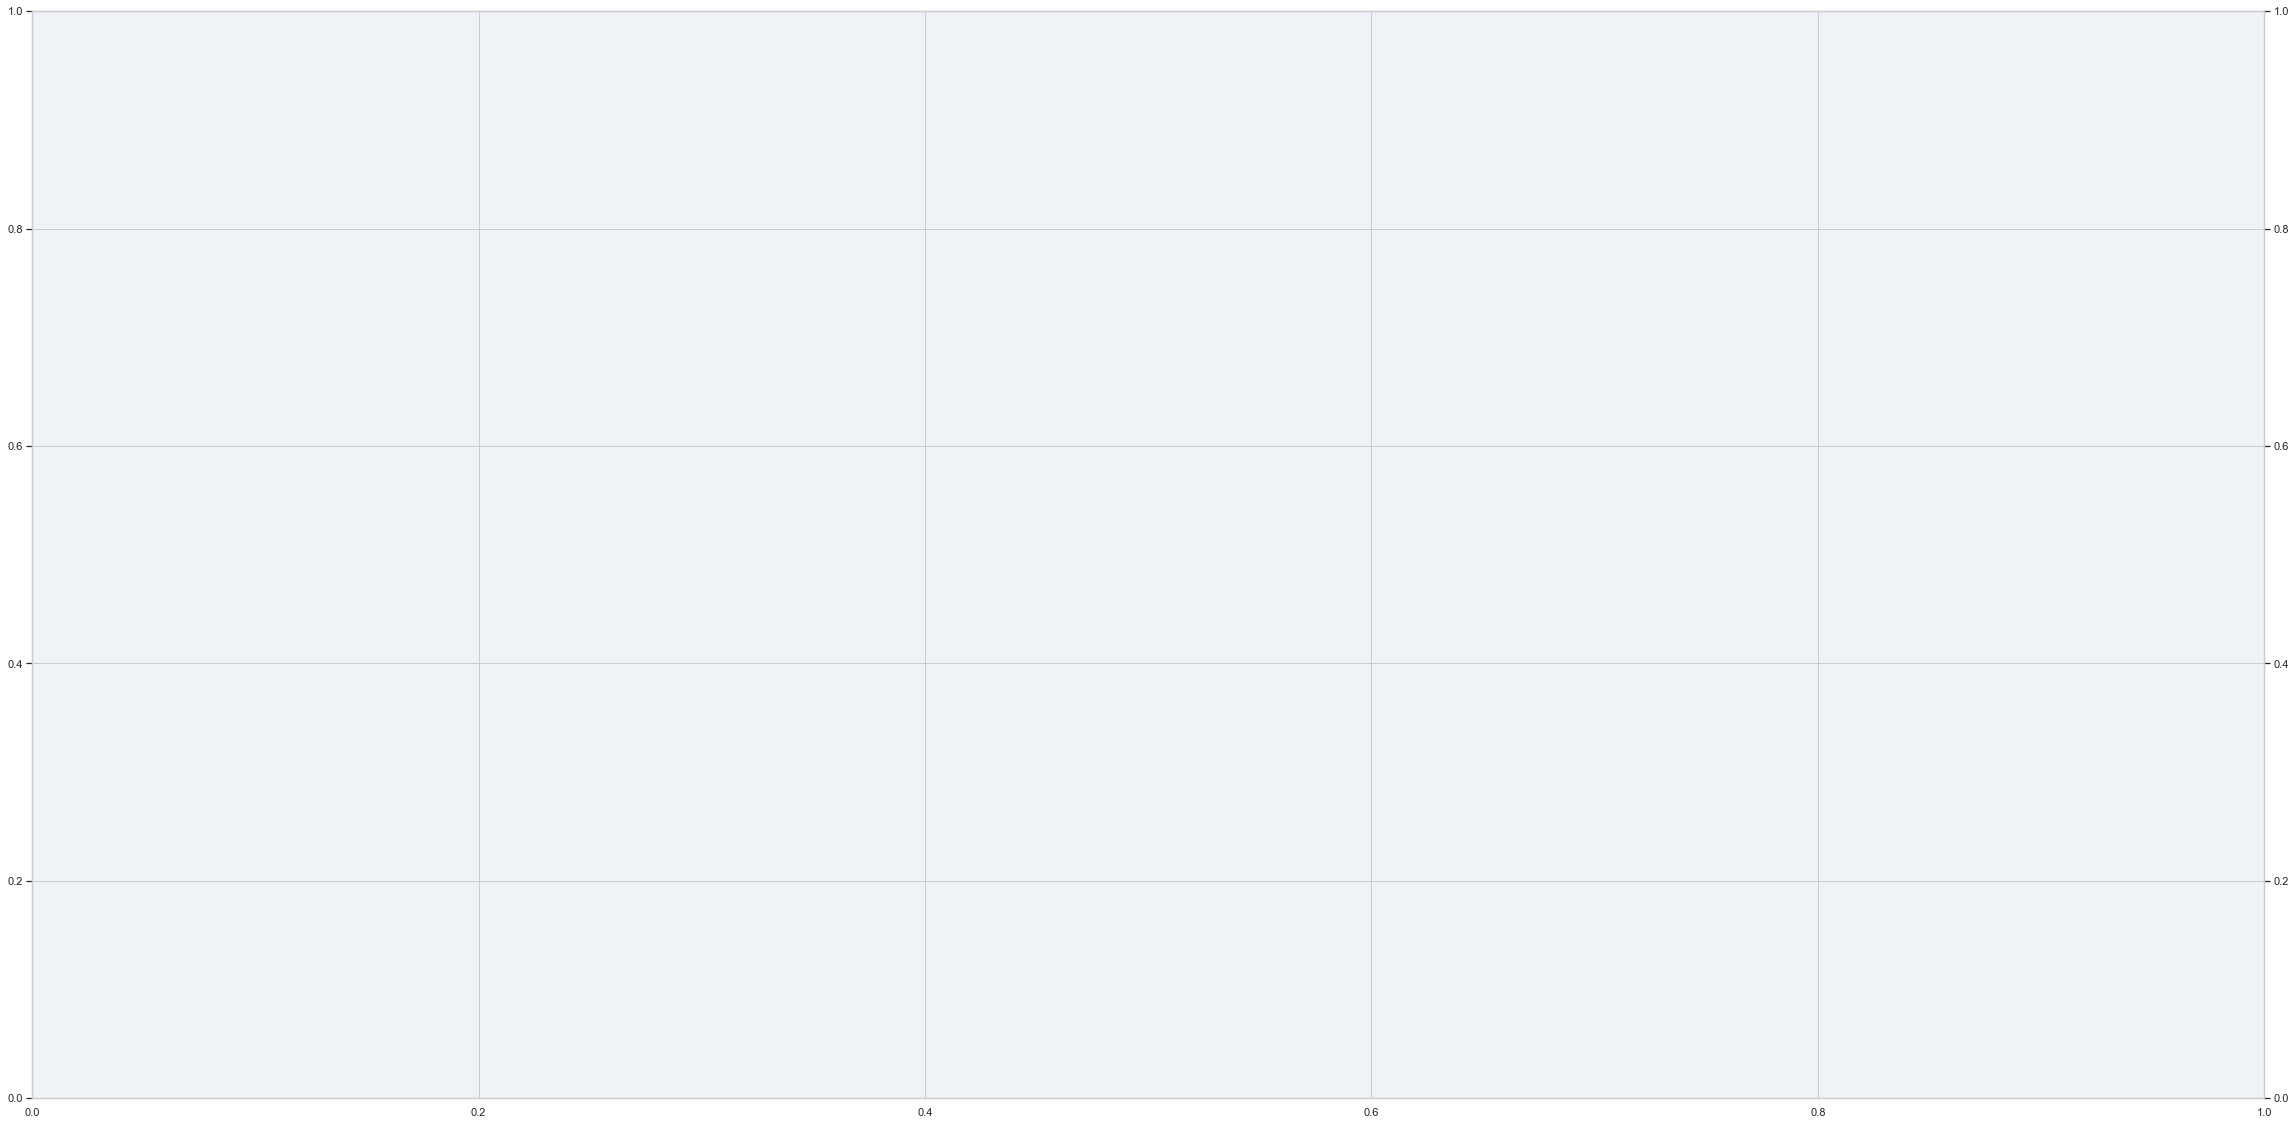

In [30]:
    plt.figure(figsize=(40, 20))
    ax2 = plt.gca().twinx()
    ax2.plot(np.cumsum(df[500:1500])+peaks[0][500:1500], rr, label="RR-intervals", color="#A651D8", linewidth=2, markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=18)
    print (np.cumsum(df[500:1500])+peaks[0], rr)
    ax2.set_xlim(start, stop)
    ax2.set_ylim(-2000, 2000)
    ax2.legend(loc="upper right", fontsize=20)

    plt.xlabel("Time (ms)", fontsize=16)
    plt.ylabel("RR-interval (ms)", fontsize=16)